In [1]:
import numpy as np
import math
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.autograd as autograd
import torchvision.transforms as transforms
from torch.autograd import Variable
from torch.nn.parameter import Parameter
from scipy.misc import imresize

import matplotlib.pyplot as plt
%matplotlib inline
import pylab as pl
from IPython import display
import time

torch.cuda.set_device(1)

In [2]:
class Block(nn.Module):
    def __init__(self, insize, outsize):
        super(Block, self).__init__()
        self.layers = nn.Sequential(
            nn.Conv2d(insize, outsize, kernel_size=3, padding=1),
            nn.BatchNorm2d(outsize),
            nn.ReLU()
        )
        
    def forward(self, inp):
        return self.layers(inp)

class ENCODER(nn.Module):
    def __init__(self):
        super(ENCODER, self).__init__()
        self.process = nn.Sequential(
            Block(3,64),
            nn.MaxPool2d(2),
            Block(64,64),
            nn.MaxPool2d(2),
            Block(64,64),
            nn.MaxPool2d(2),
            Block(64,64)
        )
        self.pool = nn.AvgPool2d(10)
        
    def forward(self, inp):
        out = self.process(inp[:,:3,:,:])
#         outmask = self.LSM(self.rechannel(out).view(out.size(0),-1)).view(out.size(0),1,
#                                                                           out.size(2),out.size(2))
        return self.pool(out).squeeze(),out
    
class PREDICTOR(nn.Module):
    def __init__(self):
        super(PREDICTOR, self).__init__()
        self.sm = nn.LogSoftmax(dim=-1)
        self.sm2 = nn.Softmax(dim=1)
        
    def forward(self, support, inp, way):
        assert support.size(0)%way == 0,"Error: classes are not the same size!"
        support = support.view(way,support.size(0)//way,-1)
        centroids = torch.mean(support, 1).view(support.size(0),-1)
        dists = (centroids.unsqueeze(0)-inp.unsqueeze(1))**2*-1 # batch, way, channels        
        distmat = torch.sum(dists,2).squeeze()
        probs = self.sm(distmat)
        
        channelpreds = self.sm2(dists)
        kld = torch.sum(channelpreds*torch.log(channelpreds*way),1).squeeze()
        
        return probs, kld/kld.norm(2,-1).unsqueeze(1)

In [3]:
preprocess = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[.485,.456,.406],std=[.229,.224,.225])])
raw = torch.load('/data/imagenet/photos-annotated-0-augmented.pth')
trainset = [[[preprocess(r[1]),torch.Tensor(imresize(r[2],(10,10))).unsqueeze(0)/255] 
            for r in cat] for cat in raw]
raw = torch.load('/data/imagenet/photos-annotated-0-test.pth')
testset = [[[preprocess(r[1]),torch.Tensor(imresize(r[2],(10,10))).unsqueeze(0)/255] 
            for r in cat] for cat in raw]
del raw

In [4]:
def batchmaker(way,trainshot,testshot,theset,alterful=False):
    classes = np.random.choice(len(theset),way,replace=False)
    li = [[[theset[cl][i][0].view(1,3,84,84),theset[cl][i][1].view(1,10,10)] for i in 
           np.random.choice(len(theset[cl]),trainshot+testshot,replace=False)]
          for cl in classes]
    support = torch.cat([torch.cat([p[0] for p in t[:trainshot]],dim=0) for t in li],dim=0)
    smask = torch.cat([torch.cat([p[1] for p in t[:trainshot]],dim=0) for t in li],dim=0)
    stargs = torch.LongTensor([i//trainshot for i in range(trainshot*way)])
    query = torch.cat([torch.cat([p[0] for p in t[trainshot:]],dim=0) for t in li],dim=0)
    qmask = torch.cat([torch.cat([p[1] for p in t[trainshot:]],dim=0) for t in li],dim=0)
    qtargs = torch.LongTensor([i//testshot for i in range(testshot*way)])
#     print(support.size(),query.size())
    return(Variable(support).cuda(),
           Variable(smask, requires_grad=False).cuda(),
           Variable(stargs).cuda(),
           Variable(query, volatile=(not alterful)).cuda(),
           Variable(qmask, requires_grad=False).cuda(),
           Variable(qtargs, volatile=(not alterful)).cuda()
          )

def evaluate(embed,model,criterion,way,trainshot,testshot,reps,theset):
    masktracker = 0
    losstracker = 0
    acctracker = 0
    acclist = []
    for i in range(reps):
        s,_,_,q,qmask,qt = batchmaker(way,trainshot,testshot,theset)
        embeds,_ = embed(s)
        qembeds,maps = embed(q)
        preds,weights = model(embeds,qembeds,way)
        
        # Val loss
        loss = criterion(preds,qt)
        losstracker += loss.data[0]
        maskloss = mcriterion(weights,maps,qmask)
        masktracker += maskloss.data[0]
        
        # Val accuracy
        _,bins = torch.max(preds,1)
        acc = torch.sum(torch.eq(bins,qt)).data[0]/testshot/way
        acctracker += acc
        acclist.append(acc)
    return losstracker/reps,acctracker/reps,masktracker/reps

way = 20
evalway = 5
trainshot = 5
testshot = 15
reps = 100

In [48]:
embed = ENCODER().cuda()
model = PREDICTOR().cuda()
losstracker,mlosstracker,evallosstracker,evalmlosstracker,evalacctracker = [],[],[],[],[]
optimizer = None
nweights = sum([i.numel() for i in list(embed.parameters())])
print(nweights," parameters in neural net.")

113088  parameters in neural net.


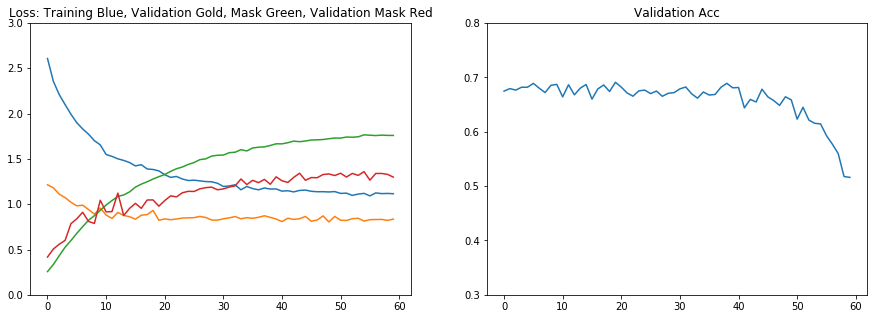

Train loss is: 1.1157260224223138
Mask MSE loss is: 1.7588882303237916

Validation accuracy is: 0.6746666666666666
Validation loss is: 0.8357219031453132
Validation mask loss is: 1.2986889880895616

1565.0581240653992


In [49]:
# TRAIN!

class maskLoss(nn.Module):
    def __init__(self):
        super(maskLoss, self).__init__()
        self.rel = nn.ReLU()
        
    def forward(self, weights, maps, targ):
        return torch.mean(self.rel(torch.sum(maps*weights.view(-1,64,1,1),1)-targ*2))

criterion = nn.NLLLoss()
mcriterion = maskLoss()
vbity = 200
epoch = 3000
start = time.time()
factor = 1
limit = 5*epoch

runningloss = 0
runningmloss = 0
for it in range(limit):
    if it%10==0:
        print(it)
    
    # Build batch
    support, _, _, query, qmask, targs = batchmaker(way,trainshot,testshot,trainset,alterful=True)
    
    # Predict
    embed.zero_grad()
    model.zero_grad()
    embeds,_ = embed(support)
    qembeds,maps = embed(query)
    preds,weights = model(embeds,qembeds,way)

    # Calculate Loss
    loss = criterion(preds, targs)
    runningloss += loss.data[0]
    mloss = mcriterion(weights,maps,qmask)
    runningmloss += mloss.data[0]*factor
    
    # Backprop
    if it%epoch == 0:
        optimizer = optim.Adam(embed.parameters(),lr=.001/(2**(it//epoch)))
    totalloss = loss+mloss/(1+100*(it/limit))
    totalloss.backward()
#     nn.utils.clip_grad_norm(model.parameters(), 1)
    optimizer.step()
    
    # Report
    if it%vbity == vbity-1:
        display.clear_output(wait=True)

        losstracker.append(runningloss/vbity)
        mlosstracker.append(runningmloss/vbity)
        embed = embed.eval()
        evalloss, evalacc, evalmloss = evaluate(embed,model,criterion,evalway,trainshot,testshot,
                                                reps,testset)
        embed = embed.train()
        evallosstracker.append(evalloss)
        evalmlosstracker.append(evalmloss*factor)
        evalacctracker.append(evalacc)
        
        pl.figure(1,figsize=(15,5))
        pl.subplot(1,2,1)
        pl.plot(losstracker)
        pl.plot(evallosstracker)
        pl.plot(mlosstracker)
        pl.plot(evalmlosstracker)
        pl.ylim((0,3))
        pl.title("Loss: Training Blue, Validation Gold, Mask Green, Validation Mask Red")
        pl.subplot(1,2,2)
        pl.plot(evalacctracker[::-1])
        pl.ylim((0.3,.8))
        pl.title("Validation Acc")
        pl.show()
        
        print("Train loss is: "+str(runningloss/vbity)+
              "\nMask MSE loss is: "+str(runningmloss/vbity/factor)+
              "\n\nValidation accuracy is: "+str(evalacc)+
              "\nValidation loss is: "+str(evalloss)+
              "\nValidation mask loss is: "+str(evalmloss)+"\n")
        runningloss = 0
        runningmloss = 0
        print(time.time()-start)

# MORE RECENT TEST
        

In [50]:
criterion = nn.NLLLoss().cuda()
embed = embed.eval()
print(evaluate(embed,model,criterion,evalway,trainshot,testshot,10000,testset))
embed = embed.train()

(0.8354793617725372, 0.6775506666667523, 1.334405481517315)


In [39]:
# Linear decrease, factor of 100

criterion = nn.NLLLoss().cuda()
embed = embed.eval()
print(evaluate(embed,model,criterion,evalway,trainshot,testshot,10000,testset))
embed = embed.train()

(0.8334130230501294, 0.6782066666667529, 1.2848995870292186)


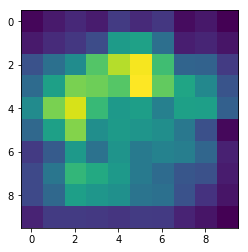

In [72]:
x = 46
plt.imshow(torch.sum(maps*weights.view(-1,64,1,1),1).squeeze()[x].data.cpu().numpy())

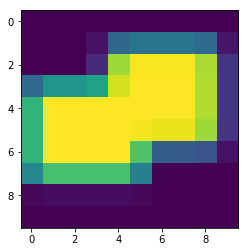

In [73]:
plt.imshow(qmask[x].data.cpu().numpy())

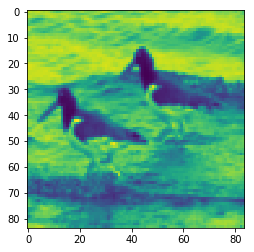

In [74]:
plt.imshow(torch.sum(query[x][:3],dim=0).data.cpu().numpy())

In [20]:
name = 'maskpredict_mse'
torch.save((embed,model,losstracker,evallosstracker,evalacctracker,mlosstracker,evalmlosstracker),
           '../saved_models/'+name+'.pth')
torch.save(embed.cpu().state_dict(),'../saved_models/'+name+'_cpu.pth')

/home/dww78/anaconda3/lib/python3.6/site-packages/torch/serialization.py:158: UserWarning: Couldn't retrieve source code for container of type ENCODER. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/dww78/anaconda3/lib/python3.6/site-packages/torch/serialization.py:158: UserWarning: Couldn't retrieve source code for container of type Block. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/dww78/anaconda3/lib/python3.6/site-packages/torch/serialization.py:158: UserWarning: Couldn't retrieve source code for container of type PREDICTOR. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


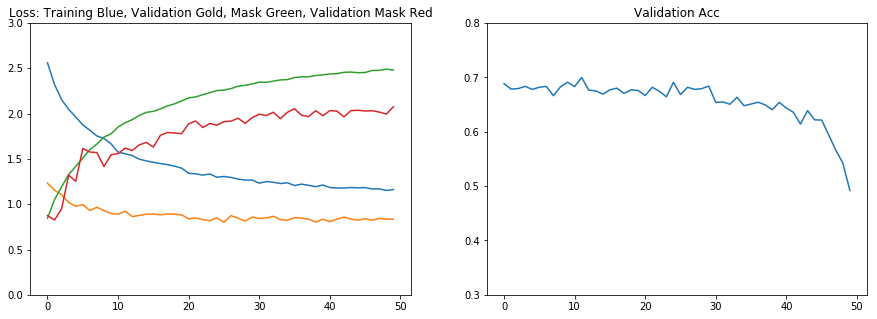

Train loss is: 1.160559274852276
Mask MSE loss is: 2.4808276569843293

Validation accuracy is: 0.6882666666666669
Validation loss is: 0.8342675119638443
Validation mask loss is: 2.0750177228450775

2054.4717049598694


In [6]:
# TRAIN!

class maskLoss(nn.Module):
    def __init__(self):
        super(maskLoss, self).__init__()
        self.rel = nn.ReLU()
        
    def forward(self, weights, maps, targ):
        return torch.mean(self.rel(torch.sum(maps*weights.view(-1,64,1,1),1)-targ*2))

criterion = nn.NLLLoss()
mcriterion = maskLoss()
vbity = 200
epoch = 2000
start = time.time()
factor = 1 #3

runningloss = 0
runningmloss = 0
for it in range(5*epoch):
    if it%10==0:
        print(it)
    
    # Build batch
    support, _, _, query, qmask, targs = batchmaker(way,trainshot,testshot,trainset,alterful=True)
    
    # Predict
    embed.zero_grad()
    model.zero_grad()
    embeds,_ = embed(support)
    qembeds,maps = embed(query)
    preds,weights = model(embeds,qembeds,way)

    # Calculate Loss
    loss = criterion(preds, targs)
    runningloss += loss.data[0]
    mloss = mcriterion(weights,maps,qmask)
    runningmloss += mloss.data[0]*factor
    
    # Backprop
    if it%epoch == 0:
        optimizer = optim.Adam(embed.parameters(),lr=.001/(2**(it//epoch)))
    totalloss = loss #+mloss
    totalloss.backward()
#     nn.utils.clip_grad_norm(model.parameters(), 1)
    optimizer.step()
    
    # Report
    if it%vbity == vbity-1:
        display.clear_output(wait=True)

        losstracker.append(runningloss/vbity)
        mlosstracker.append(runningmloss/vbity)
        embed = embed.eval()
        evalloss, evalacc, evalmloss = evaluate(embed,model,criterion,evalway,trainshot,testshot,
                                                reps,testset)
        embed = embed.train()
        evallosstracker.append(evalloss)
        evalmlosstracker.append(evalmloss*factor)
        evalacctracker.append(evalacc)
        
        pl.figure(1,figsize=(15,5))
        pl.subplot(1,2,1)
        pl.plot(losstracker)
        pl.plot(evallosstracker)
        pl.plot(mlosstracker)
        pl.plot(evalmlosstracker)
        pl.ylim((0,3))
        pl.title("Loss: Training Blue, Validation Gold, Mask Green, Validation Mask Red")
        pl.subplot(1,2,2)
        pl.plot(evalacctracker[::-1])
        pl.ylim((0.3,.8))
        pl.title("Validation Acc")
        pl.show()
        
        print("Train loss is: "+str(runningloss/vbity)+
              "\nMask MSE loss is: "+str(runningmloss/vbity/factor)+
              "\n\nValidation accuracy is: "+str(evalacc)+
              "\nValidation loss is: "+str(evalloss)+
              "\nValidation mask loss is: "+str(evalmloss)+"\n")
        runningloss = 0
        runningmloss = 0
        print(time.time()-start)

# MORE RECENT TEST
        